In [44]:
#!pip install xgboost
#!pip install lightgbm
#!pip install optuna
#!pip install imbalanced-learn smogn

In [35]:
#!pip install xgboost scikit-learn

In [16]:
#!pip install scikit-learn==1.2.2 xgboost==1.7.6 lightgbm==3.3.5


## Import library 

In [205]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from numpy import absolute
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor, RandomForestRegressor
#import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
import scipy.stats as stats
from sklearn.metrics import r2_score
from numpy.polynomial.polynomial import Polynomial
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics.pairwise import cosine_similarity
import ImbalancedLearningRegression as iblr
import seaborn
import smogn

## Loading data 

In [2]:
data= pd.read_csv("~/data_combine_ecmwf.csv")
data.tail()

,dataset_id,country,longitude,latitude,planting_date,crop,N_fertilizer,P_fertilizer,K_fertilizer,yield,...,soil_silt,soil_clay,soil_phh2o,soil_SOC,Tmean.1,TMIN,TMAX,SRAD,tmax (°C),precipitation (mm)
3164,hdl_11529_11012,Ethiopia,37.031,9.779,2016-01-01,maize,120.0,0.0,0.0,6498.697071,...,24.916667,57.333333,5.666667,2.728333,20.487603,14.611570,26.198347,20.946242,28.033609,0.0
3165,hdl_11529_11012,Ethiopia,37.190,9.130,2016-01-01,maize,0.0,0.0,0.0,5232.000000,...,32.683333,44.433333,5.400000,2.295000,21.132231,15.727273,26.413223,20.925490,26.715250,0.0
3166,hdl_11529_11012,Ethiopia,37.190,9.130,2016-01-01,maize,130.0,60.0,42.0,7213.934776,...,32.683333,44.433333,5.400000,2.295000,21.132231,15.727273,26.413223,20.925490,26.715250,0.0
3167,hdl_11529_11012,Ethiopia,37.190,9.130,2016-01-01,maize,111.0,38.0,0.0,6039.442886,...,32.683333,44.433333,5.400000,2.295000,21.132231,15.727273,26.413223,20.925490,26.715250,0.0
3168,hdl_11529_11012,Ethiopia,37.190,9.130,2016-01-01,maize,120.0,0.0,0.0,7778.491634,...,32.683333,44.433333,5.400000,2.295000,21.132231,15.727273,26.413223,20.925490,26.715250,0.0


## Data exploration

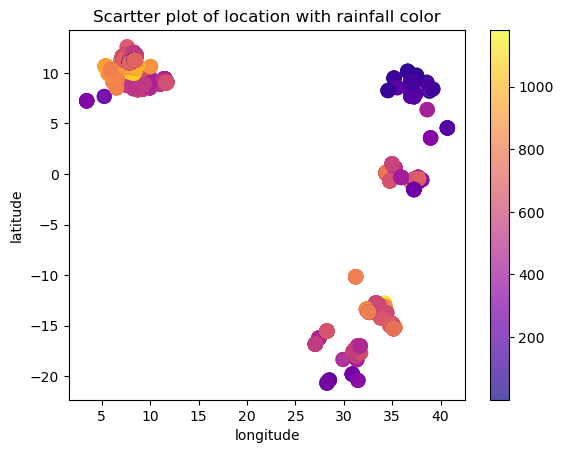

In [3]:
### scatter plot of longitude and latitude
plt.scatter(data["longitude"],data["latitude"],c=data["Total_rain"],alpha =0.7, s=100,cmap='plasma')
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("Scartter plot of location with rainfall color")
plt.colorbar()

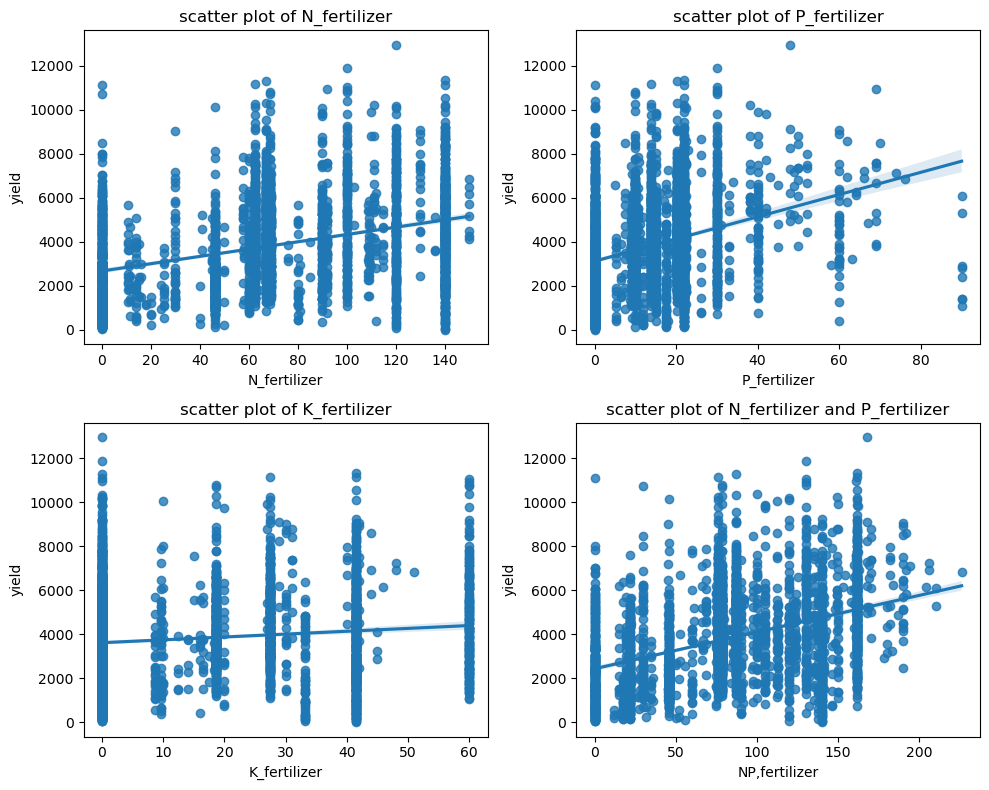

In [4]:
# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# First subplot
sns.regplot(x='N_fertilizer', y='yield', data=data, ax=axs[0, 0]) 
axs[0, 0].set_title('scatter plot of N_fertilizer')
axs[0, 0].set_xlabel('N_fertilizer')
axs[0, 0].set_ylabel('yield')

# Second subplot
sns.regplot(x='P_fertilizer', y='yield', data=data, ax=axs[0, 1])
axs[0, 1].set_title('scatter plot of P_fertilizer')
axs[0, 1].set_xlabel('P_fertilizer')
axs[0, 1].set_ylabel('yield')

# Third subplot
sns.regplot(x='K_fertilizer', y='yield', data=data, ax=axs[1, 0])
axs[1, 0].set_title('scatter plot of K_fertilizer')
axs[1, 0].set_xlabel('K_fertilizer')
axs[1, 0].set_ylabel('yield')

data1= data
data1["NP"]= data["N_fertilizer"]+data["P_fertilizer"]
# Fourth subplot
sns.regplot(x='NP', y='yield', data=data1, ax=axs[1, 1])
axs[1, 1].set_title('scatter plot of N_fertilizer and P_fertilizer')
axs[1, 1].set_xlabel('NP,fertilizer')
axs[1, 1].set_ylabel('yield')


plt.tight_layout()
plt.show()

## yield distribution

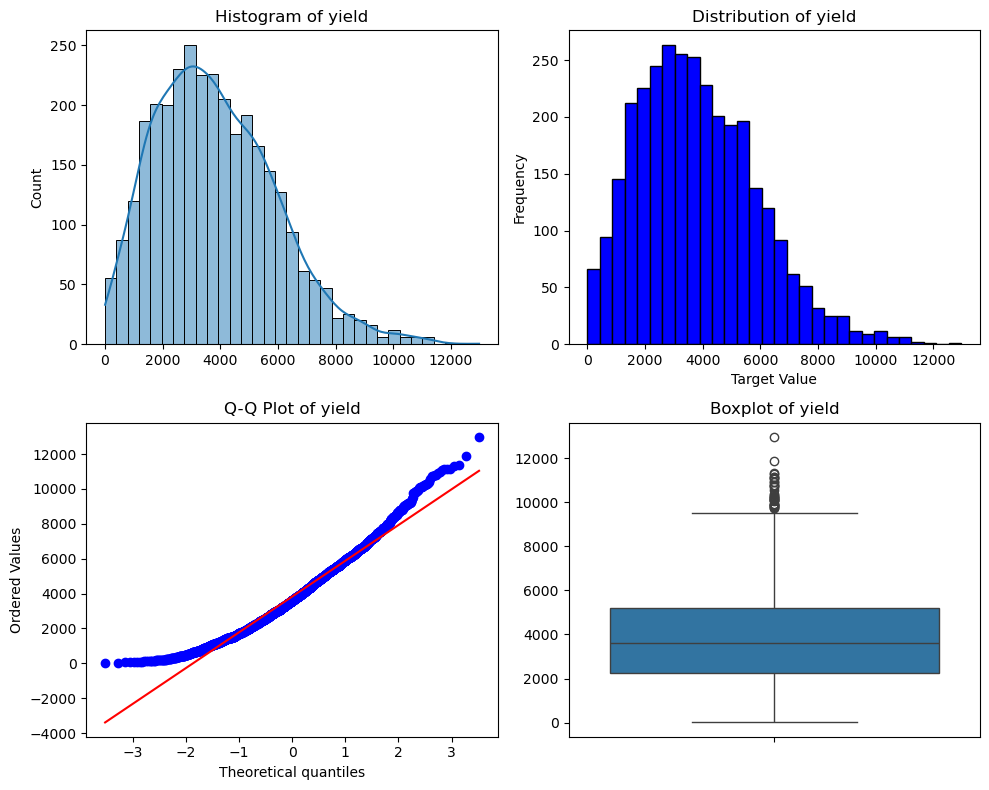

In [5]:
### Scatter plot with regression line of fertilizer
# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# First subplot
sns.histplot(data["yield"].values, kde=True, ax=axs[0, 0])
axs[0, 0].set_title('Histogram of yield')

# Second subplot
axs[0, 1].hist(data["yield"].values, bins=30, color='blue', edgecolor='black')
axs[0, 1].set_title('Distribution of yield')
axs[0, 1].set_xlabel('Target Value')
axs[0, 1].set_ylabel('Frequency')

# Third subplot
stats.probplot(data["yield"].values.ravel(), dist="norm", plot=axs[1, 0])
axs[1, 0].set_title('Q-Q Plot of yield')

# Fourth subplot
sns.boxplot(data["yield"].values, ax=axs[1, 1])
axs[1, 1].set_title('Boxplot of yield')

plt.tight_layout()
plt.show()

## Feature selection

<Axes: >

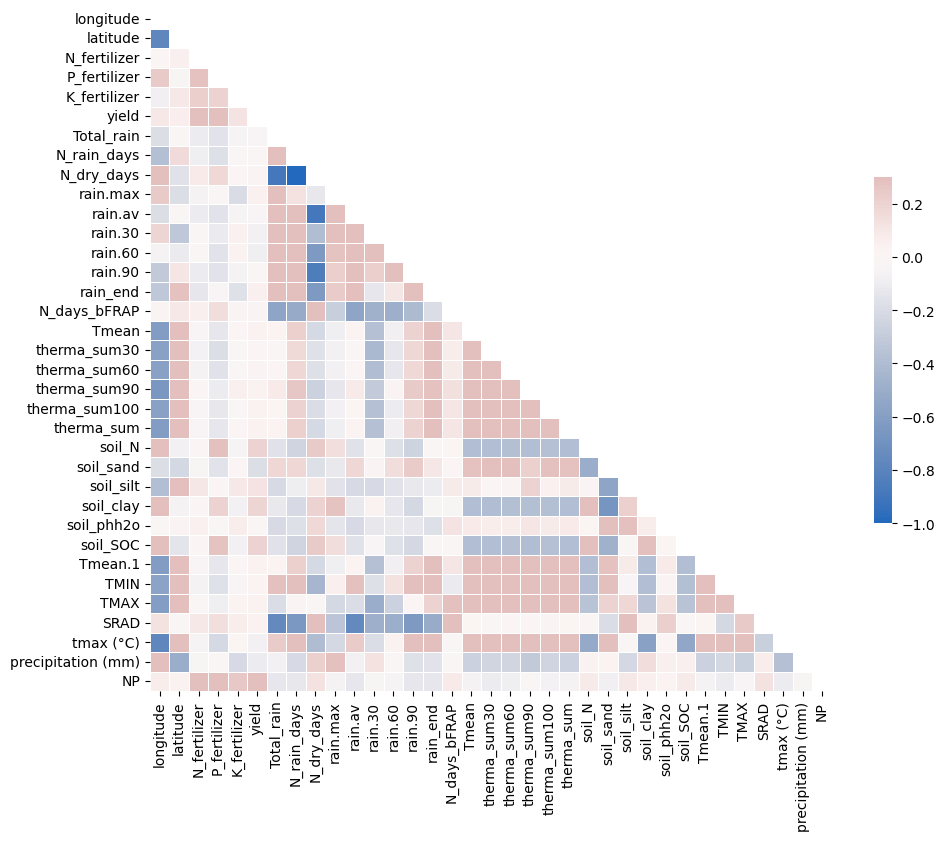

In [6]:
### Correlation metrix
correlation_data =data.select_dtypes(include=[np.number]).corr()
mask = np.zeros_like(correlation_data, dtype=bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.palette="vlag"

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_data, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [216]:
### Selected features
d1= data[[ 'TMIN', 'TMAX','Total_rain',
       'Tmean','yield',"therma_sum","N_fertilizer","P_fertilizer","K_fertilizer",
           "N_rain_days","soil_clay","soil_silt","soil_sand","soil_N",'tmax (°C)', 'precipitation (mm)']]
dff=d1.dropna()
d1=dff.reset_index(drop=True)

### Handling imbalanced data in regression focusing on yield  

In [ ]:
#!pip install ImbalancedLearningRegression

In [217]:
## conduct smote function using ImbalancedLearningRegression library
df_smote = iblr.smote(
    ## main arguments
    data =d1,  ## pandas dataframe
    y = "yield",  ## Target variable
    rel_thres = 0.6 ## relevance threshold considered rare
)

r_index: 100%|##########| 156/156 [00:00<00:00, 841.69it/s]


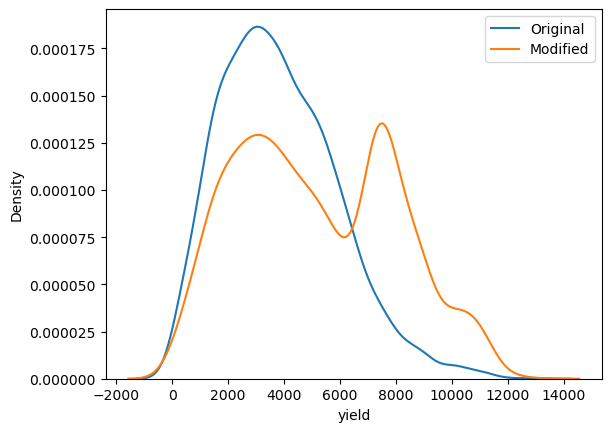

In [218]:
## plot yield distribution ( Original and Modified)
df_smote.reset_index(inplace=True)
seaborn.kdeplot(d1["yield"], label="Original")
seaborn.kdeplot(df_smote["yield"], label="Modified")
plt.legend(labels=["Original","Modified"])
plt.show()

In [219]:
### Modified dataset
d1= df_smote 

In [220]:
### Subset the data into two parts

### Data with historical weather 
df_H= d1[['TMIN', 'TMAX','Total_rain',
       'Tmean','yield',"therma_sum","N_fertilizer","P_fertilizer","K_fertilizer",
           "N_rain_days","soil_clay","soil_silt","soil_sand","soil_N"]]

### Data with seasonal forecast                           
df_w= d1[['TMIN','tmax (°C)','precipitation (mm)',
       'Tmean','yield',"therma_sum","N_fertilizer","P_fertilizer","K_fertilizer",
           "N_rain_days","soil_clay","soil_silt","soil_sand","soil_N"]]

In [221]:
### Removing potential duplicates data 
#d_clean_H=df_H.loc[:, df_H.columns != 'yield'] ### data with Hiqtorical
#d_unique_H=df_H.drop_duplicates(subset=d_clean_H.columns,keep="first").reset_index(drop=True)
### Using OneHotEncoder 
d_onhot_H= pd.get_dummies(df_H)
## Select input data
features=d_onhot_H.loc[:, d_onhot_H.columns != 'yield']
## Target variable
Target=d_onhot_H['yield']

In [222]:
### Scale and plit the data into training and testing set
scale = preprocessing.MinMaxScaler()
feature = scale.fit_transform(features)
feature = pd.DataFrame(feature, columns=features.columns)
X_train, X_test, y_train, y_test = train_test_split(feature, Target, test_size=0.20, random_state=42)

/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasatt

## Modelization 

In [223]:
# Evaluating model
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = np.sqrt(mean_squared_error(y_test, predictions))
    MAE= metrics.mean_absolute_error(y_test, predictions)
    r2=r2_score(y_test,predictions)
    print('Model Performance')
    return ( print('RMSE: ', errors), print('MAE: ', MAE), print('r2: ', r2))

### Random Forest 

In [224]:
best_params= {'bootstrap': True, 'max_depth':None, 'max_features': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
rf = RandomForestRegressor(**best_params, random_state=42)
rf.fit(X_train,y_train)

/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(

RandomForestRegressor(max_features=20, n_estimators=400, random_state=42)

In [225]:
##Testing  and training set
evaluate(rf, X_test,y_test), evaluate(rf, X_train,y_train)

/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(

Model Performance
RMSE:  1543.7576040938854
MAE:  1124.407398341983
r2:  0.7104224335958025
Model Performance
RMSE:  574.6956952544373
MAE:  419.459319783744
r2:  0.9580585598582371


/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

((None, None, None), (None, None, None))

<Axes: >

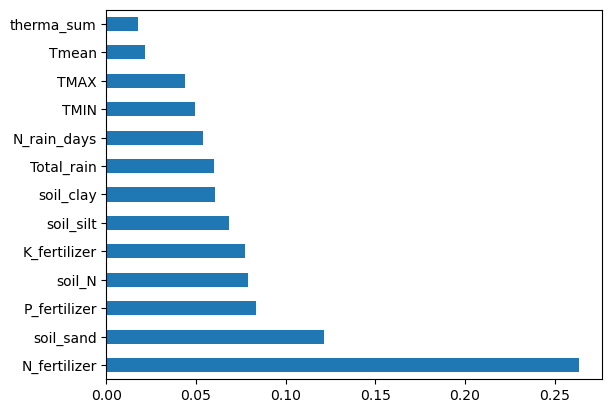

In [226]:
# Feature importance
feat_importances = pd.Series(rf.feature_importances_, index=features.columns)
fim=feat_importances.sort_values(ascending=False).head(25)
fim.plot(kind='barh')

#### Light gradient boosting 

In [227]:
lgbm= lgb.LGBMRegressor(n_estimators= 400, random_state=42)
lgbm.fit(X_train,y_train)
## model evaluation
evaluate(lgbm, X_test,y_test), evaluate(lgbm, X_train,y_train)

Model Performance
RMSE:  1415.0836266579684
MAE:  1043.5052728302753
r2:  0.756683866644299
Model Performance
RMSE:  617.4551967512517
MAE:  448.2635191096499
r2:  0.9515851767221499


/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

((None, None, None), (None, None, None))

### Extreme gradient boosting 

In [228]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor(
    n_estimators=400,  
    max_depth=10,       
    learning_rate=0.4, 
    objective='reg:squarederror', 
    gamma=0,
    min_child_weight=5,
    random_state=42
)
# Train the model
xgb_model.fit(X_train, y_train)
# Make evaluation
evaluate(xgb_model, X_test,y_test), evaluate(xgb_model, X_train,y_train)

/opt/conda/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/opt/conda/lib/python3.

Model Performance
RMSE:  1541.4053180387934
MAE:  1112.8848249346363
r2:  0.7113042434173655
Model Performance
RMSE:  146.1577976323689
MAE:  28.62086209384978
r2:  0.997287239637541


/opt/conda/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/opt/conda/lib/python3.

((None, None, None), (None, None, None))

### voting model

In [229]:
import xgboost as xgb
lgbm_model = lgb.LGBMRegressor(n_estimators= 400, random_state=42)
xgb_model1 = xgb.XGBRegressor(n_estimators= 400,gamma= 0, learning_rate=0.4,max_depth= 10,min_child_weight=5, random_state=42) # Change xgb.XGBRegressor to XGBRegressor
rf_model = RandomForestRegressor(**best_params, random_state=42)
# Pass instances to VotingRegressor
model = VotingRegressor(estimators=[('lgb', lgbm_model), ('xgb', xgb_model1), ('rf', rf_model)], n_jobs=5)
model.fit(X_train, y_train)


/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/opt/conda/lib/python3.1

VotingRegressor(estimators=[('lgb',
                             LGBMRegressor(n_estimators=400, random_state=42)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=0, gpu_id=None,
                                          grow_policy=None,
                                          importance...
                                          learning_rate=0.4, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=10,
                                          max_leaves=None, min_child_weight=5,
                                          missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=400, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=42, ...)),
                            ('rf',
                             RandomForestRegressor(max_features=20,
                                                   n_estimators=400,
                                                   random_state=42))],
                n_jobs=5)

In [230]:
evaluate(model, X_test,y_test), evaluate(model, X_train,y_train)

/opt/conda/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/opt/conda/lib/python3.

Model Performance
RMSE:  1420.994826152661
MAE:  1021.762864275673
r2:  0.7546468219816137


/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Model Performance
RMSE:  391.5777885031776
MAE:  280.3920392471854
r2:  0.9805283143722547


/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

((None, None, None), (None, None, None))

In [245]:
### Visualization

/opt/conda/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/opt/conda/lib/python3.

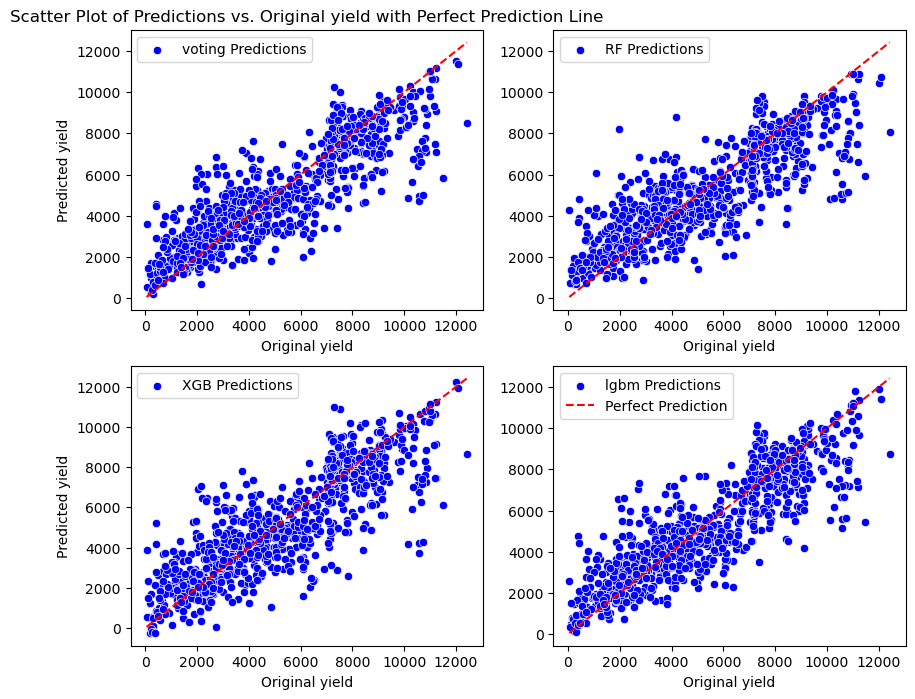

In [231]:
# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# First subplot
y_pred= model.predict(X_test)
# Convert y_test to a 1D array
sns.scatterplot(x=y_test.values.ravel(), y=y_pred, color='blue', label='voting Predictions',ax=axs[0, 0])
# Plot the perfect prediction line (y = x)
axs[0, 0].plot([min(y_test.values), max(y_test.values)], [min(y_test.values), max(y_test.values)], color='red', linestyle='--', label='Perfect Prediction')
# Add labels and title
axs[0, 0].set_xlabel('Original yield')
axs[0, 0].set_ylabel('Predicted yield')
axs[0, 0].set_title('Scatter Plot of Predictions vs. Original yield with Perfect Prediction Line')
plt.legend()


# Second subplot
y_pred= rf.predict(X_test)
# Convert y_test to a 1D array
sns.scatterplot(x=y_test.values.ravel(), y=y_pred, color='blue', label='RF Predictions',ax=axs[0, 1])
# Plot the perfect prediction line (y = x)
axs[0, 1].plot([min(y_test.values), max(y_test.values)], [min(y_test.values), max(y_test.values)], color='red', linestyle='--', label='Perfect Prediction')
# Add labels and title
axs[0, 1].set_xlabel('Original yield')
#axs[0, 1].set_ylabel('Predicted yield')
plt.legend()

# third subplot
y_pred= xgb_model.predict(X_test)
# Convert y_test to a 1D array
sns.scatterplot(x=y_test.values.ravel(), y=y_pred, color='blue', label='XGB Predictions',ax=axs[1, 0])
# Plot the perfect prediction line (y = x)
axs[1, 0].plot([min(y_test.values), max(y_test.values)], [min(y_test.values), max(y_test.values)], color='red', linestyle='--', label='Perfect Prediction')
# Add labels and title
axs[1, 0].set_xlabel('Original yield')
axs[1, 0].set_ylabel('Predicted yield')
plt.legend()

# fouth subplot
y_pred= lgbm.predict(X_test)
# Convert y_test to a 1D array
sns.scatterplot(x=y_test.values.ravel(), y=y_pred, color='blue', label='lgbm Predictions',ax=axs[1, 1])
# Plot the perfect prediction line (y = x)
axs[1, 1].plot([min(y_test.values), max(y_test.values)], [min(y_test.values), max(y_test.values)], color='red', linestyle='--', label='Perfect Prediction')
# Add labels and title
axs[1, 1].set_xlabel('Original yield')
#axs[1, 1].set_ylabel('Predicted yield')
plt.legend()
# Show plot
plt.show()

### Assessment of Seasonal weather forecast

In [232]:
## preparing data with seasonal forecast
df_w.columns = df_H.columns
features_w= df_w.drop(columns=['yield'])
scale = preprocessing.MinMaxScaler()
feature_w = scale.fit_transform(features_w)
feature_w = pd.DataFrame(feature_w, columns=features_w.columns)

/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasatt

In [233]:
### Samples of data containing Weather forecast 
Target_w= df_H["yield"] ## yield
X_valid=feature_w.iloc[X_train.index] ##
y_valid= Target_w[X_train.index]

In [234]:
### Evaluating the performance of seasonal WF
evaluate(model, X_valid,y_valid)

/opt/conda/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/opt/conda/lib/python3.

Model Performance
RMSE:  1188.0032096340337
MAE:  893.3161619946341
r2:  0.8207733123333885


/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

(None, None, None)

In [235]:
### Creating a Data frame  with both predicted crop yield and the Observe yield
ypre=model.predict(X_train) ## Historical weather data
pred= pd.DataFrame(ypre, columns=["predicted"])
ypre_wf=model.predict(X_valid) ## Seasonal weather forecast data
predwf= pd.DataFrame(ypre_wf, columns=["predicted_wf"]) 
dcom= pd.concat([pred,predwf], axis=1) ### 
dcom["original"]=y_valid.reset_index(drop=True) ## adding observe crop yield
dcom["rain"]= features["Total_rain"].iloc[y_train.index].reset_index(drop=True) ## Adding rainfall columns
dcom.tail()

/opt/conda/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/opt/conda/lib/python3.

,predicted,predicted_wf,original,rain
3607,6421.058831,6472.985939,6519.000000,548.688584
3608,7277.576532,7295.626534,7180.257903,459.195798
3609,4163.177174,4143.021550,3462.000000,546.807221
3610,4446.492737,4335.052831,4762.000000,511.760823
3611,7734.040214,7942.816516,7887.056107,900.584082


### Evaluating the performance under different rainfall Scenarios (Low, High and Medium)

In [236]:
def rain_scenarios(rain, data):
    if rain <400 :
      d= data[data["rain"]<400] ### low rainfall 
    elif rain > 800:
        d= data[data["rain"]> 800]
    else:
        d= data[(data["rain"]>=400)& (data["rain"]<=800)] ### medium rainfall  
    RMSE = np.sqrt(mean_squared_error(d["original"], d["predicted"]))
    RMSE_WF = np.sqrt(mean_squared_error(d["original"], d["predicted_wf"]))
    MAE= metrics.mean_absolute_error(d["original"], d["predicted"])
    MAE_WF= metrics.mean_absolute_error(d["original"], d["predicted_wf"])
    r2=r2_score(d["original"], d["predicted"])
    r2_WF=r2_score(d["original"], d["predicted_wf"])
    return RMSE, RMSE_WF, MAE, MAE_WF, r2,r2_WF


In [237]:
rain_scenarios(100, dcom) # Low rainfall
#rain_scenarios(1000, dcom) # High rainfall
#rain_scenarios(400, dcom) # Medium rainfall

/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

(407.09023399980526,
 954.4644430043127,
 279.3014032581067,
 706.3759501039563,
 0.9810534750916811,
 0.8958479780305466)